In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

tf.config.run_functions_eagerly(True)

In [3]:
ACTION_NUM = 5

In [15]:
powerful_model = tf.keras.models.load_model('./model/powerful_lstm')

In [16]:
model_list = []
for i in range(ACTION_NUM):
    model_list.append(tf.keras.models.load_model('./model/action_net/action_net{0}/'.format(i)))
    
model_list.append(powerful_model)

In [5]:
dnn_model = tf.keras.models.load_model('./model/dnn.h5')

In [6]:
def shift_data(origin, d):
    shift_d = tf.concat((origin[0][1::], d), axis=0).reshape(1, 60, 21)
    return shift_d

In [7]:
df = pd.read_excel('./nov_nine_var.xlsx').iloc[:,1::].to_numpy()

scaler = MinMaxScaler()
scale_df = scaler.fit_transform(df)

data = tf.constant(scale_df[:,0:21][-1-60:-1].reshape(1, 60, 21), dtype=tf.float32)

In [9]:
goal_bf = scaler.transform(pd.read_excel('./basic_formula.xlsx').iloc[:,1::].to_numpy())
goal_bf = tf.constant(goal_bf[:,0:21][np.argmin(goal_bf[:,-1])].reshape(1, 21), dtype=tf.float32)

goal_ae = scaler.transform(pd.read_excel('./ae_formula.xlsx').iloc[:,1::].to_numpy())
goal_ae = tf.constant(goal_ae[:,0:21][np.argmin(goal_ae[:,-1])].reshape(1, 21), dtype=tf.float32)

goal_dqn = scaler.transform(pd.read_excel('./dqn.xlsx').iloc[:,1::].to_numpy())
goal_dqn = tf.constant(goal_dqn[:,0:21][np.argmin(goal_dqn[:,-1])].reshape(1, 21), dtype=tf.float32)

In [10]:
class Node:
    def __init__(self, parent, state):
        self.parent = parent
        self.child = None
        self.state = state

In [17]:
class Tree:
    def __init__(self, leaf_num, grow_type):
        self.root = None
        self.state_list = []
        self.type = grow_type
        self.leaf_num = leaf_num
        self.size = 0
        self.depth = 1

    def _size(self):
        i = 0
        t = self.size
        while True:
            t -=  self.leaf_num**i
            i += 1

            if t == 0:
                break

        self.depth = i

    @tf.function
    def average_the_state(self, node, child_state):
        state = tf.Variable(tf.zeros((6, 1, 21)))
        for i in range(5):
            state[i].assign(child_state[i][0][-1].reshape(1, 21))

        mean_state = tf.reduce_mean(state, 0)
        return mean_state

    @tf.function
    def sort_by_value(self, node, child_state):
        value = tf.Variable(tf.zeros(6))
        for i in range(6):
            state = child_state[i][:, -1]
            value[i].assign(dnn_model(state)[0][0])

        argsort_order = tf.argsort(value)
        return argsort_order

    def push(self, state):
        node = Node(None, state)
        
        node.child = [Node for i in range(self.leaf_num)]
        child_state = tf.Variable(tf.zeros((6, 1, 60, 21)))

        for i in range(6):
            child_state[i].assign(shift_data(state, model_list[i](state)))

        if self.type == 'min':
            sorting_child_state = self.sort_by_value(node, child_state)
            for j in range(self.leaf_num):
                i = sorting_child_state[j]
                node.child[j] = Node(node, child_state[i])

        if self.type == 'mean':
            mean_child_state = self.average_the_state(node, child_state)
            for i in range(self.leaf_num):
                node.child[i] = Node(node, shift_data(state, mean_child_state))

        self.size += 1

        return node

    def post_order(self):
        self.state_arr = tf.constant(tf.zeros((1, 2), dtype=tf.float16))
        def _post_order(node, rank):
            if node.child != None:
                for i in range(self.leaf_num):
                    _post_order(node.child[i], rank+1)

            value = dnn_model(node.state[0][-1].reshape(1, 21))[0]
            node = tf.stack((tf.cast(value, dtype=tf.float16), rank), axis=1)
            self.state_arr = tf.concat((self.state_arr, node), axis=0)

        _post_order(self.root, tf.cast([1], dtype=tf.float16))

In [18]:
def grow(leaf, grow_type, end):
    def _grow(tree, node, t, end):
        if t >= end:
            return

        for i in range(leaf):
            node.child[i] = tree.push(node.child[i].state)
            _grow(tree, node.child[i], t+1, end)

    tree = Tree(leaf, grow_type)
    tree.root = tree.push(data)
    _grow(tree, tree.root, 0, end)

    return tree

grow
order
draw


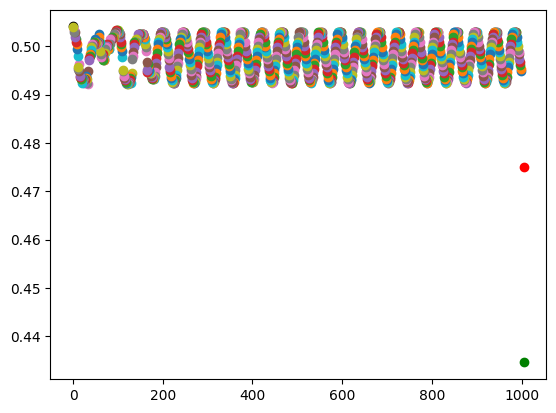

In [24]:
e = 1000

print('grow')

tree = grow(1, 'min', e-3)

print('order')

tree.post_order()

print('draw')

l = tree.state_arr
plt.scatter(0, dnn_model(data[:, -1]), c='black')

for i in range(1, l.shape[0]):
    plt.scatter(l[i][1], l[i][0])

plt.scatter(e+5, dnn_model(goal_bf), c='')
plt.scatter(e+5, dnn_model(goal_ae), c='g')
plt.show()

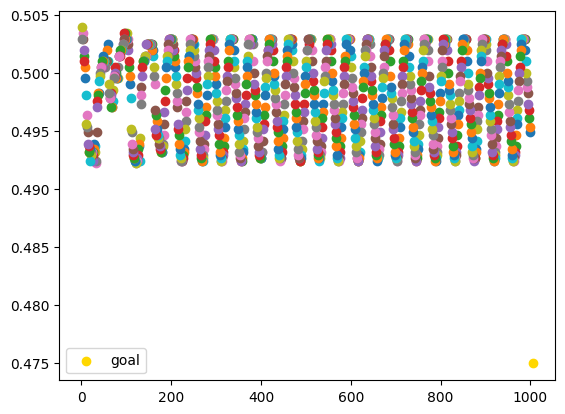

In [28]:
for i in range(1, l.shape[0]):
    plt.scatter(l[i][1], l[i][0])

plt.scatter(e+5, dnn_model(goal_bf), c='gold', label='goal')

plt.legend()
plt.savefig('./d.png')
plt.show()

In [29]:
type(l)

tensorflow.python.framework.ops.EagerTensor

In [31]:
l = l.numpy()
l_df = pd.DataFrame(l)

In [ ]:
l_df.s